In [1]:
!pip install mlxtend
!pip install ptitprince
!pip install lightgbm
!pip install mlxtend
!pip install ptitprince
!pip install RainCloud

In [1]:

# Googleドライブへのマウント
from google.colab import drive
drive.mount('/content/drive')
%cd "/content/drive/My Drive/"

Mounted at /content/drive
/content/drive/My Drive


In [2]:
# import sys
# sys.path.append('/content/drive/MyDrive/Colab Notebooks/pip')

In [4]:
# !pip install --target /content/drive/MyDrive/Colab\ Notebooks/pip ptitprince

In [3]:
import pandas as pd
import os
import numpy as np
from matplotlib_venn import venn2
import matplotlib.pyplot as plt
import seaborn as sns
from ptitprince import RainCloud

In [5]:
INPUT_DIR="dataset/atma10"
OUTPUT_DIR="Colab Notebooks/atma#10/output"

#データ読み込み

In [6]:
train_df=pd.read_csv(os.path.join(INPUT_DIR,"train.csv"))
test_df=pd.read_csv(os.path.join(INPUT_DIR,"test.csv"))
color_df=pd.read_csv(os.path.join(INPUT_DIR,"color.csv"))
person_df=pd.read_csv(os.path.join(INPUT_DIR,"historical_person.csv"))
maker_df=pd.read_csv(os.path.join(INPUT_DIR,"maker.csv"))
material_df=pd.read_csv(os.path.join(INPUT_DIR,"material.csv"))
palette_df=pd.read_csv(os.path.join(INPUT_DIR,"palette.csv"))
tech_df=pd.read_csv(os.path.join(INPUT_DIR,"technique.csv"))
proplace_df=pd.read_csv(os.path.join(INPUT_DIR,"production_place.csv"))

#EDA

In [32]:
# わかりやすさのため底を 10 とした log 変換
train_df['log_likes'] = np.log10(train_df['likes'] + 1)

In [ ]:
fig, ax = plt.subplots(figsize=(8, 5))
RainCloud(data=train_df, y='log_likes', orient='h', ax=ax)
ax.grid()

In [ ]:
desc_length = train_df['description'].str.len().rename('desc_length')
fig, ax = plt.subplots(figsize=(20, 6))
RainCloud(y=train_df['log_likes'], 
          x=pd.cut(desc_length, bins=10, duplicates='drop'), ax=ax)
ax.grid()

In [ ]:
sub_title_length = train_df['sub_title'].str.len().rename('subtitle_length')
fig, ax = plt.subplots(figsize=(20, 6))
RainCloud(y=train_df['log_likes'], 
          x=pd.cut(sub_title_length, bins=10, duplicates='drop'), ax=ax)
ax.grid()

#特徴量の作成

In [7]:
class AbstractBaseBlock:
    def fit(self, input_df: pd.DataFrame, y=None):
        return self.transform(input_df)
    
    def transform(self, input_df: pd.DataFrame) -> pd.DataFrame:
        raise NotImplementedError()

In [8]:
def run_blocks(input_df, blocks, y=None, test=False):
    out_df = pd.DataFrame()
    
    print(decorate('start run blocks...'))

    with Timer(prefix='run test={}'.format(test)):
        for block in feature_blocks:
            with Timer(prefix='\t- {}'.format(str(block))):
                if not test:
                    out_i = block.fit(input_df, y=y)
                else:
                    out_i = block.transform(input_df)

            assert len(input_df) == len(out_i), block
            name = block.__class__.__name__
            out_df = pd.concat([out_df, out_i.add_suffix(f'@{name}')], axis=1)
        
    return out_df

In [9]:
# https://github.com/nyk510/vivid/blob/master/vivid/utils.py
from time import time

def decorate(s: str, decoration=None):
    if decoration is None:
        decoration = '★' * 20
        
    return ' '.join([decoration, str(s), decoration])

class Timer:
    def __init__(self, logger=None, format_str='{:.3f}[s]', prefix=None, suffix=None, sep=' ', verbose=0):

        if prefix: format_str = str(prefix) + sep + format_str
        if suffix: format_str = format_str + sep + str(suffix)
        self.format_str = format_str
        self.logger = logger
        self.start = None
        self.end = None
        self.verbose = verbose

    @property
    def duration(self):
        if self.end is None:
            return 0
        return self.end - self.start

    def __enter__(self):
        self.start = time()

    def __exit__(self, exc_type, exc_val, exc_tb):
        self.end = time()
        if self.verbose is None:
            return
        out_str = self.format_str.format(self.duration)
        if self.logger:
            self.logger.info(out_str)
        else:
            print(out_str)

##text以外の特徴量

In [10]:
class StringLengthBlock(AbstractBaseBlock):
    def __init__(self, column):
        self.column = column
    
    def transform(self, input_df):
        out_df = pd.DataFrame()
        out_df[self.column] = input_df[self.column].str.len()
        return out_df.add_prefix('StringLength_')

In [11]:
class SizeAreaBlock(AbstractBaseBlock):
    def __init__(self, column):
        self.column = column
    
    def transform(self, input_df):
        out_df = pd.DataFrame()
        for axis in ['h', 'w', 't', 'd']:
            column_name = f'size_{axis}'
            size_info = input_df['sub_title'].str.extract(r'{} (\d*|\d*\.\d*)(cm|mm)'.format(axis)) # 正規表現を使ってサイズを抽出
            size_info = size_info.rename(columns={0: column_name, 1: 'unit'})
            size_info[column_name] = size_info[column_name].replace('', np.nan).astype(float) # dtypeがobjectになってるのでfloatに直す
            size_info[column_name] = size_info.apply(lambda row: row[column_name] * 10 if row['unit'] == 'cm' else row[column_name], axis=1) # 　単位をmmに統一する
            out_df[column_name] = size_info[column_name] # inputにくっつける
        out_df["AreaSize"]=out_df["size_h"]*out_df["size_w"]/100
        return out_df

In [12]:
class OneHotEncoding(AbstractBaseBlock):
    def __init__(self, column, min_count=30):
        self.column = column
        self.min_count = min_count
        
    def fit(self, input_df, y=None):
        x = input_df[self.column]
        vc = x.value_counts()
        categories = vc[vc > self.min_count].index
        self.categories_ = categories
        
        return self.transform(input_df)
    
    def transform(self, input_df):
        x = input_df[self.column]
        cat = pd.Categorical(x, categories=self.categories_)
        out_df = pd.get_dummies(cat)
        out_df.columns = out_df.columns.tolist()
        return out_df.add_prefix(f'{self.column}=')

In [13]:
def read_whole_df():
    return pd.concat([
        pd.read_csv(os.path.join(INPUT_DIR,"train.csv")),pd.read_csv(os.path.join(INPUT_DIR,"test.csv"))
    ], ignore_index=True)

class CountEncodingBlock(AbstractBaseBlock):
    """CountEncodingを行なう block"""
    def __init__(self, column: str):
        self.column = column

    def fit(self, input_df, y=None):
#         vc = input_df[self.column].value_counts()
        master_df = read_whole_df()
        vc = master_df[self.column].value_counts()
        self.count_ = vc
        return self.transform(input_df)

    def transform(self, input_df):
        out_df = pd.DataFrame()
        out_df[self.column] = input_df[self.column].map(self.count_)
        return out_df.add_prefix('CE_')

In [14]:
OBJECT_ID = 'object_id'
def left_join(left, right, on=OBJECT_ID):
    if isinstance(left, pd.DataFrame):
        left = left[on]
    return pd.merge(left, right, on=on, how='left').drop(columns=[on])

In [15]:
def create_palette_feature(input_df):
    output_df = input_df.copy()
    palette = palette_df

    # ratio最大のものを取得
    max_palette = palette.groupby('object_id')['ratio'].max().reset_index()
    max_palette = pd.merge(max_palette, palette, on=['object_id','ratio'], how='left').rename(
        columns={"ratio":"max_ratio", "color_r":"max_palette_r", "color_g":"max_palette_g","color_b":"max_palette_b"})  
    max_palette = max_palette.loc[max_palette["object_id"].drop_duplicates().index.tolist()].reset_index()  # 同じidでmax ratioが同じものは削除
    output_df = pd.merge(output_df, max_palette, on="object_id", how="left")

    # 平均のrgbを取得
    mean_palette = palette.copy()
    mean_palette["color_r"] = palette["ratio"] * palette["color_r"]
    mean_palette["color_g"] = palette["ratio"] * palette["color_g"]
    mean_palette["color_b"] = palette["ratio"] * palette["color_b"]
    mean_palette = mean_palette.groupby("object_id").sum().reset_index().rename(
        columns={"color_r":"mean_palette_r", "color_g":"mean_palette_g","color_b":"mean_palette_b"})
    output_df = pd.merge(output_df, mean_palette, on="object_id", how="left")

    use_columns = ["object_id","max_ratio", "max_palette_r","max_palette_g","max_palette_b","mean_palette_r","mean_palette_g","mean_palette_b"]
    return output_df[use_columns]

In [16]:
class PaletteBlock(AbstractBaseBlock):
    def fit(self, input_df, y=None):
        self.agg_df_=create_palette_feature(input_df)
        return self.transform(input_df)
    
    def transform(self, input_df):
        out_df = left_join(input_df, self.agg_df_)
        return out_df.add_prefix(f'PaletteBlock_name=')

In [17]:
class TakeTimeBlock(AbstractBaseBlock):
    def __init__(self):
        pass
    def transform(self, input_df):
        y=[ ]
        # out_df = pd.DataFrame()
        for i in range(input_df.shape[0]):
            takeyears=input_df["dating_year_late"][i]-input_df["dating_year_early"][i]
            y.append(takeyears)
        out_df=pd.DataFrame(y)
        return out_df

In [ ]:
class TargetEncodingBlock(AbstractBaseBlock):
    def __init__(self,column):
        self.column=column
    def transform(self, input_df):
        

In [18]:
feature_blocks = [
    TakeTimeBlock()
]

In [ ]:
# block=Ac_credit_Encoding()
train_check_df=run_blocks(train_df, blocks=feature_blocks)
train_check_df

In [19]:
class MaterialBlock(AbstractBaseBlock):
    def __init__(self, min_count=30):
        self.min_count = min_count
    
    def fit(self, input_df, y=None):
        # material_df = read_csv('material')
        
        vc = material_df['name'].value_counts()
        # 出現回数30以上に絞る
        use_names = vc[vc >= self.min_count].index

        # isin で 30 回以上でてくるようなレコードに絞り込んでから corsstab を行なう
        idx = material_df['name'].isin(use_names)
        _use_df = material_df[idx].reset_index(drop=True)
        
        self.agg_df_ = pd.crosstab(_use_df['object_id'], _use_df['name'])
        return self.transform(input_df)
    
    def transform(self, input_df):
        out_df = left_join(input_df, self.agg_df_)
        return out_df.add_prefix(f'MaterialBlock_name=')

In [20]:
class TechBlock(AbstractBaseBlock):
    def __init__(self, min_count=30):
        self.min_count = min_count
    
    def fit(self, input_df, y=None):
        
        
        vc = tech_df['name'].value_counts()
        # 出現回数30以上に絞る
        use_names = vc[vc >= self.min_count].index

        # isin で 30 回以上でてくるようなレコードに絞り込んでから corsstab を行なう
        idx = tech_df['name'].isin(use_names)
        _use_df = tech_df[idx].reset_index(drop=True)
        
        self.agg_df_ = pd.crosstab(_use_df['object_id'], _use_df['name'])
        return self.transform(input_df)
    
    def transform(self, input_df):
        out_df = left_join(input_df, self.agg_df_)
        return out_df.add_prefix(f'TechniqueBlock_name=')

In [21]:
class ProductionPlaceBlock(AbstractBaseBlock):
    def __init__(self, min_count=10):
        self.min_count = min_count
    
    def fit(self, input_df, y=None):
        
        # proplace_df
        vc = proplace_df['name'].value_counts()
        # 出現回数30以上に絞る
        use_names = vc[vc >= self.min_count].index

        # isin で 30 回以上でてくるようなレコードに絞り込んでから corsstab を行なう
        idx =proplace_df['name'].isin(use_names)
        _use_df = proplace_df[idx].reset_index(drop=True)
        
        self.agg_df_ = pd.crosstab(_use_df['object_id'], _use_df['name'])
        return self.transform(input_df)
    
    def transform(self, input_df):
        out_df = left_join(input_df, self.agg_df_)
        return out_df.add_prefix(f'proplace_dfBlock_name=')

In [22]:
class HistoricalPersonBlock(AbstractBaseBlock):
    def __init__(self, min_count=30):
        self.min_count = min_count
    
    def fit(self, input_df, y=None):
        vc = person_df['name'].value_counts()
        # 出現回数30以上に絞る
        use_names = vc[vc >= self.min_count].index

        # isin で 30 回以上でてくるようなレコードに絞り込んでから corsstab を行なう
        idx = person_df['name'].isin(use_names)
        _use_df = person_df[idx].reset_index(drop=True)
        
        self.agg_df_ = pd.crosstab(_use_df['object_id'], _use_df['name'])
        return self.transform(input_df)
    
    def transform(self, input_df):
        out_df = left_join(input_df, self.agg_df_)
        return out_df.add_prefix(f'HistoricalPersonBlock_name=')

##text特徴量

In [ ]:
!pip install texthero

In [ ]:
import texthero as hero
import nltk

nltk.download('stopwords')
os.listdir(os.path.expanduser('~/nltk_data/corpora/stopwords/'))

In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline

In [26]:
def text_normalization(text):
    
    # 英語とオランダ語を stopword として指定
    custom_stopwords = nltk.corpus.stopwords.words('dutch') + nltk.corpus.stopwords.words('english')

    x = hero.clean(text, pipeline=[
        hero.preprocessing.fillna,
        hero.preprocessing.lowercase,
        hero.preprocessing.remove_digits,
        hero.preprocessing.remove_punctuation,
        hero.preprocessing.remove_diacritics,
        lambda x: hero.preprocessing.remove_stopwords(x, stopwords=custom_stopwords)
    ])
    
    return x

class TfidfBlock(AbstractBaseBlock):
    """tfidf x SVD による圧縮を行なう block"""
    def __init__(self, column: str):
        """
        args:
            column: str
                変換対象のカラム名
        """
        self.column = column
    
    def preprocess(self, input_df):
        x = text_normalization(input_df[self.column])
        return x
    
    def get_master(self, input_df):
        """tdidfを計算するための全体集合を返す. 
        デフォルトでは fit でわたされた dataframe を使うが, もっと別のデータを使うのも考えられる."""
        return input_df
    
    def fit(self, input_df, y=None):
        master_df = self.get_master(input_df)
        text = self.preprocess(input_df)
        self.pileline_ = Pipeline([
            ('tfidf', TfidfVectorizer(max_features=10000)),
            ('svd', TruncatedSVD(n_components=50)),
        ])
        
        self.pileline_.fit(text)
        return self.transform(input_df)
    
    def transform(self, input_df):
        text = self.preprocess(input_df)
        z = self.pileline_.transform(text)
        
        out_df = pd.DataFrame(z)
        return out_df.add_prefix(f'{self.column}_tfidf_')

##確認用

In [30]:
# feature_blocks = [
#     *[OneHotEncoding(c, min_count=20) for c in ['title', 'description', 'long_title',
#        'principal_maker', 'principal_or_first_maker', 'sub_title',
#        'copyright_holder', 'more_title', 'acquisition_method',
#        'acquisition_date', 'acquisition_credit_line', 'dating_presenting_date',
#        'dating_sorting_date', 'dating_period', 'dating_year_early',
#        'dating_year_late',]],
#     *[CountEncodingBlock(c) for c in ['art_series_id', 'title', 'description', 'long_title',
#        'principal_maker', 'principal_or_first_maker', 'sub_title',
#        'copyright_holder', 'more_title', 'acquisition_method',
#        'acquisition_date', 'acquisition_credit_line', 'dating_presenting_date',
#        'dating_sorting_date', 'dating_period', 'dating_year_early',
#        'dating_year_late',]],
#     *[StringLengthBlock(c) for c in [
#         'title', 'description', 'long_title',
#        'principal_maker', 'principal_or_first_maker', 'sub_title',
#     ]],
#     *[SizeAreaBlock(c) for c in [
#         'sub_title',
#     ]]
# ]

In [31]:
# run_blocks(train_df, blocks=feature_blocks)
# run_blocks(test_df, blocks=feature_blocks, test=True)

##学習

In [27]:
feature_blocks = [
    *[OneHotEncoding(c, min_count=20) for c in ['title', 'description', 'long_title',
       'principal_maker', 'principal_or_first_maker', 'sub_title',
       'copyright_holder', 'more_title', 'acquisition_method',
       'acquisition_date', 'acquisition_credit_line', 'dating_presenting_date',
       'dating_sorting_date', 'dating_period', 'dating_year_early',
       'dating_year_late',]],
    *[CountEncodingBlock(c) for c in ['art_series_id', 'title', 'description', 'long_title',
       'principal_maker', 'principal_or_first_maker', 'sub_title',
       'copyright_holder', 'more_title', 'acquisition_method',
       'acquisition_date', 'acquisition_credit_line', 'dating_presenting_date',
       'dating_sorting_date', 'dating_period', 'dating_year_early',
       'dating_year_late',]],
    *[StringLengthBlock(c) for c in [
        'title', 'description', 'long_title',
       'principal_maker', 'principal_or_first_maker', 'sub_title',
    ]],
    *[SizeAreaBlock(c) for c in [
        'sub_title',
    ]],
    # PaletteBlock(),
    ProductionPlaceBlock(),
    MaterialBlock(),
    TechBlock(),
    HistoricalPersonBlock(),
    TakeTimeBlock(),
    TfidfBlock('description'),
    # TfidfBlock('acquisition_method'),
    TfidfBlock('title'),
    TfidfBlock('long_title')
]
train_feat_df = run_blocks(train_df, blocks=feature_blocks, test=False)

★★★★★★★★★★★★★★★★★★★★ start run blocks... ★★★★★★★★★★★★★★★★★★★★
	- <__main__.OneHotEncoding object at 0x7f11476af250> 0.032[s]
	- <__main__.OneHotEncoding object at 0x7f11476af210> 0.009[s]
	- <__main__.OneHotEncoding object at 0x7f11476af1d0> 0.009[s]
	- <__main__.OneHotEncoding object at 0x7f11476af410> 0.008[s]
	- <__main__.OneHotEncoding object at 0x7f11476af450> 0.008[s]
	- <__main__.OneHotEncoding object at 0x7f11476af4d0> 0.009[s]
	- <__main__.OneHotEncoding object at 0x7f11476af510> 0.007[s]
	- <__main__.OneHotEncoding object at 0x7f11476af550> 0.010[s]
	- <__main__.OneHotEncoding object at 0x7f11476af590> 0.004[s]
	- <__main__.OneHotEncoding object at 0x7f11476af490> 0.006[s]
	- <__main__.OneHotEncoding object at 0x7f11476af5d0> 0.006[s]
	- <__main__.OneHotEncoding object at 0x7f11476af610> 0.007[s]
	- <__main__.OneHotEncoding object at 0x7f11476af650> 0.009[s]
	- <__main__.OneHotEncoding object at 0x7f11476af690> 0.003[s]
	- <__main__.OneHotEncoding object at 0x7f11476af6d0> 0.

In [28]:
import lightgbm as lgbm
from sklearn.metrics import mean_squared_error
from typing import Union, Optional, Iterable

def fit_lgbm(X: np.ndarray, 
             y: np.ndarray, 
             cv: Iterable, 
             y_max: Optional[float] = None,
             params: Optional[dict] = None, 
             verbose: Optional[int] =50):
    """lightGBM を CrossValidation の枠組みで学習を行なう function"""

    # パラメータがないときは、空の dict で置き換える
    if params is None:
        params = {}
    is_silent = verbose is None
    is_cut_y = y_max is not None
        
    models = []
    # training data の target と同じだけのゼロ配列を用意
    oof_pred = np.zeros_like(y, dtype=np.float)
    for i, (idx_train, idx_valid) in enumerate(cv): 
        # この部分が交差検証のところです。データセットを cv instance によって分割します
        # training data を trian/valid に分割
        x_train, y_train = X[idx_train], y[idx_train]
        x_valid, y_valid = X[idx_valid], y[idx_valid]
        
        # 最大値が決まっている場合, 学習するデータだけ丸めを行なう
        if is_cut_y:
            idx_use = y_train < y_max
            y_train = np.where(idx_use, y_train, y_max)
        clf = lgbm.LGBMRegressor(**params)

        with Timer(prefix='fit fold={} '.format(i), verbose=verbose):
            clf.fit(x_train, y_train, 
                    eval_set=[(x_valid, y_valid)],  
                    early_stopping_rounds=100,
                    verbose=verbose)

        pred_i = clf.predict(x_valid)
        oof_pred[idx_valid] = pred_i
        models.append(clf)
        
        if not is_silent:
            print(f'Fold {i} RMSLE: {mean_squared_error(y_valid, pred_i) ** .5:.4f}')

    if not is_silent:
        score = mean_squared_error(y, oof_pred) ** .5
        print('Whole RMSLE: {:.4f}'.format(score))
    return oof_pred, models,score

params = {
    # 目的関数. これの意味で最小となるようなパラメータを探します. 
    'objective': 'rmse', 

     # 学習率. 小さいほどなめらかな決定境界が作られて性能向上に繋がる場合が多いです、
    # がそれだけ木を作るため学習に時間がかかります
    'learning_rate': .1,

    # L2 Reguralization
    'reg_lambda': 1.,
    # こちらは L1 
    'reg_alpha': .1,

    # 木の深さ. 深い木を許容するほどより複雑な交互作用を考慮するようになります
    'max_depth': 5, 

    # 木の最大数. early_stopping という枠組みで木の数は制御されるようにしていますのでとても大きい値を指定しておきます.
    'n_estimators': 10000, 

    # 木を作る際に考慮する特徴量の割合. 1以下を指定すると特徴をランダムに欠落させます。小さくすることで, まんべんなく特徴を使うという効果があります.
    'colsample_bytree': .5, 

    # 最小分割でのデータ数. 小さいとより細かい粒度の分割方法を許容します.
    'min_child_samples': 10,

    # bagging の頻度と割合
    'subsample_freq': 3,
    'subsample': .9,

    # 特徴重要度計算のロジック(後述)
    'importance_type': 'gain', 
    'random_state': 0,
}

y = train_df['likes'].values
y = np.log1p(y)
from sklearn.model_selection import KFold

fold = KFold(n_splits=5, shuffle=True, random_state=71)
cv = list(fold.split(train_feat_df, y)) # もともとが generator なため明示的に list に変換する



In [ ]:
print(decorate('start training'))
oof, models,cv_score = fit_lgbm(train_feat_df.values, y, cv, params=params, verbose=500)
print(decorate('FINISHED'))

In [ ]:
def visualize_importance(models, feat_train_df):
    """lightGBM の model 配列の feature importance を plot する
    CVごとのブレを boxen plot として表現します.

    args:
        models:
            List of lightGBM models
        feat_train_df:
            学習時に使った DataFrame
    """
    feature_importance_df = pd.DataFrame()
    for i, model in enumerate(models):
        _df = pd.DataFrame()
        _df['feature_importance'] = model.feature_importances_
        _df['column'] = feat_train_df.columns
        _df['fold'] = i + 1
        feature_importance_df = pd.concat([feature_importance_df, _df], 
                                          axis=0, ignore_index=True)

    order = feature_importance_df.groupby('column')\
        .sum()[['feature_importance']]\
        .sort_values('feature_importance', ascending=False).index[:50]

    fig, ax = plt.subplots(figsize=(8, max(6, len(order) * .25)))
    sns.boxenplot(data=feature_importance_df, 
                  x='feature_importance', 
                  y='column', 
                  order=order, 
                  ax=ax, 
                  palette='viridis', 
                  orient='h')
    ax.tick_params(axis='x', rotation=90)
    ax.set_title('Importance')
    ax.grid()
    fig.tight_layout()
    return fig, ax

fig, ax = visualize_importance(models, train_feat_df)

In [ ]:
test_feat_df = run_blocks(input_df=test_df, blocks=feature_blocks, test=True)

In [67]:
def revert_to_real(y_log):
    _pred = np.expm1(y_log)
    _pred = np.where(_pred < 0, 0, _pred)
    return _pred
pred = np.array([model.predict(test_feat_df.values) for model in models])
pred = np.mean(pred, axis=0)
pred = revert_to_real(pred)
sub_df = pd.DataFrame({ 'likes': pred })
sub_df.to_csv(os.path.join(OUTPUT_DIR, str(num)+'__submission.csv'), index=False)

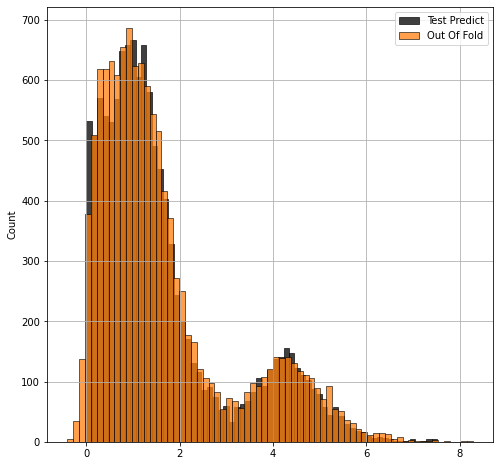

In [68]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.histplot(np.log1p(pred), label='Test Predict', ax=ax, color='black')
sns.histplot(oof, label='Out Of Fold', ax=ax, color='C1')
ax.legend()
ax.grid()

#記録用

In [66]:
num=8
zipname=str(num)+"sub"

In [72]:
# たとえばこんな感じで実行したら notebook をコピーするとかもいいかも
import shutil

shutil.copy('Colab Notebooks/atma#10/atma_10.ipynb', OUTPUT_DIR)
if num>1:
    os.remove(os.path.join(OUTPUT_DIR, str(num-1)+'__submission.csv'))
# まとめて zipfile 化するという手もある
shutil.make_archive(os.path.join(os.path.dirname(OUTPUT_DIR), zipname), 'zip', OUTPUT_DIR)



'/content/drive/My Drive/Colab Notebooks/atma#10/7sub.zip'

In [69]:
public=0.9949
private=1.0165

In [ ]:
break

In [70]:
li=[[num,'{:.5f}'.format(cv_score),public,private]]
df = pd.DataFrame(li)
df.columns = ["n","CV","public","private"]
df.to_csv(os.path.join(OUTPUT_DIR, 'sublog.csv'),mode="a",header=False,index=False)


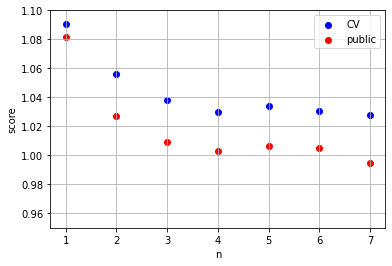

In [71]:
from matplotlib.ticker import *

sub_df=pd.read_csv(os.path.join(OUTPUT_DIR, 'sublog.csv'))
x=sub_df["n"]
y=sub_df["CV"]
y2=sub_df["public"]
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.scatter(x,y, c='b',label="CV")
ax.scatter(x,y2, c='r',label="public")
ax.set_xlabel('n')
ax.set_ylabel('score')
ax.legend(loc='upper right')
ax.xaxis.set_major_locator(MultipleLocator(1)) 
plt.ylim(0.95,1.1)
ax.grid(True)
fig.show()
plt.savefig(os.path.join(OUTPUT_DIR,'subdata.png'))

In [48]:
#1 baseline
#2 tfidf
#3 matelial
#4 technique
#7 何年かけて作ったか